# CH10-迁移学习

[官方链接](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

### 迁移学习

如果要训练一个检测网络，但是数据集很小，为了能有一个优秀的特征提取器(ConvNet)，先在大的数据集(如ImageNet，120万张图片，1000个类别)上训练ConvNet，然后将训练好的ConcNet放在自己的小数据集上继续训练，这个过程就是“迁移学习”。

迁移学习的三个使用场景：

+ ConvNet作为固定提取器。取一个在 ImageNet 上预训练的 ConvNet，移除最后一个全连接层（该层的输出是 ImageNet 任务的 1000 个类别的分数），然后将 ConvNet 的其余部分视为新数据集的固定特征提取器。

+ 微调 ConvNet。 取在ImageNet上预训练好的ConvNet，修改或者替换网络层，重新训练。

+ 直接使用预训练的模型。


如何微调：

+ 新数据集很小并且与大型数据集相似。可能出现过拟合；

+ 新数据集很大并且与大型数据集相似。这种情况下，一般不会出现过拟合；

+ 新数据集很小，与大型数据集不相似，保留前部分，然后从该部分开始训练；

+ 新数据集很大，与大型数据集合不相似，从头训练比较好。

Note:

+ 微调的模型，训练过程中，学习率设定应该较小；

该示例中，我们将冻结除最终的全连接层之外的所有网络的权重：最后一个全连接层被一个具有随机权重的新层替换，并且只训练这一新层。


In [6]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## 1-加载数据

将使用 torchvision 和 torch.utils.data 包来加载数据。

问题：训练一个模型来对蚂蚁和蜜蜂进行分类 。

120 张蚂蚁和蜜蜂的训练图像，每个类有 75 个验证图像，该数据集是 imagenet 的一个非常小的子集。

[数据集下载](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data_ch10/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                  data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True, num_workers=0) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 图像可视化



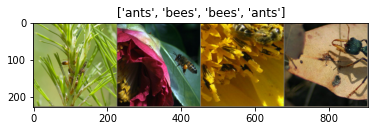

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 2-定义训练和评估函数

接下来，我们需要定义一个模型训练函数，该函数包括以下部分：


+ 训练模型，记录损失和准确率

+ 调整学习率大小。在一个epoch结束后，调整学习率




In [9]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## 3-微调

+ 加载预训练模型，并修改模型的最后一层全连接层。

+ 定义损失函数

+ 定义优化器

+ 定义学习率微调策略

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\admin/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth
100.0%


训练模型

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7896 Acc: 0.6352
val Loss: 1.2154 Acc: 0.6013

Epoch 1/24
----------
train Loss: 0.8573 Acc: 0.7131
val Loss: 0.3097 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.5263 Acc: 0.7746
val Loss: 0.3196 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.5381 Acc: 0.7705
val Loss: 0.2832 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.4231 Acc: 0.8156
val Loss: 0.3648 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.5094 Acc: 0.8156
val Loss: 0.2721 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4423 Acc: 0.8033
val Loss: 0.2529 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3743 Acc: 0.8402
val Loss: 0.2188 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3603 Acc: 0.8361
val Loss: 0.2096 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2921 Acc: 0.8811
val Loss: 0.2469 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3299 Acc: 0.8566
val Loss: 0.1992 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3279 Acc: 0.8484
val Loss: 0.2116 Acc: 0.9216

Ep

In [16]:
# 保存模型
torch.save(model_ft, 'data_ch10/model.pth')

# 加载模型使用：
# model = torch.load('data_ch10/model.pth')

## 4-可视化模型预测

显示一些图像预测的通用函数

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

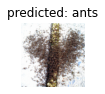

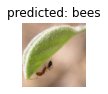

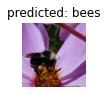

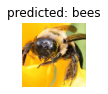

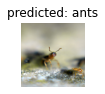

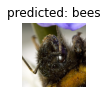

In [18]:
# 可视化
visualize_model(model_ft)

## 5- 将ConvNet作为固定特征提取器

预训练模型的最后一层全连接层，其输出向量的维度为1000（对于ImageNet的num_classes=1000）
。直接将该模型作为特征提取器，我们只需要修改最后一层全连接层的输出维度为2，然后冻结其余所有层的参数，只训练最后一层全连接层即可。

In [19]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

训练和评估


In [20]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7041 Acc: 0.6393
val Loss: 0.2652 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4529 Acc: 0.7951
val Loss: 0.1947 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.5818 Acc: 0.7172
val Loss: 0.2902 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.5105 Acc: 0.8033
val Loss: 0.1661 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.5808 Acc: 0.7828
val Loss: 0.3257 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.4367 Acc: 0.8361
val Loss: 0.1869 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4716 Acc: 0.7869
val Loss: 0.4524 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.4360 Acc: 0.8074
val Loss: 0.1814 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3281 Acc: 0.8730
val Loss: 0.1800 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2922 Acc: 0.8934
val Loss: 0.1719 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3893 Acc: 0.8033
val Loss: 0.2268 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3573 Acc: 0.8443
val Loss: 0.2303 Acc: 0.9216

Ep

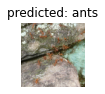

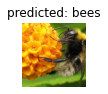

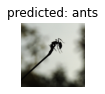

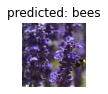

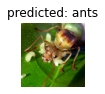

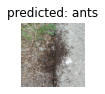

In [21]:
visualize_model(model_conv)

plt.ioff()
plt.show()